# Network Colocalization Notebook

This notebook examines the network convergence results for the initial study pairs.

**Inputs:**
* Supplemental Table 1 - Input Information (`outputs/STable1.tsv`) 
* Supplemental Table 2 - NetColoc Results (`outputs/STable2.tsv`)
* Supplemental Table 7 - Additional NetColoc Testing (`outputs/STable6.tsv`)

**Figures generated:**
- Figure 2B
- Figure 2C
- Figure 2D
- Supplemental Figure 1B
- Supplemental Figure 1C

### Set Up

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import mannwhitneyu
import re
from tqdm import tqdm
from statsmodels.stats.multitest import fdrcorrection
import random
import sys

In [2]:
cwd = os.getcwd()
datadir = os.path.join(cwd, '..')

In [3]:
sys.path.append(os.path.join(datadir, 'carva'))
from geneset_utils import load_full_gene_profile

In [4]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.5
import matplotlib.font_manager as fm
arial_font_path = os.path.join(datadir, 'Reference_Data', 'Arial.TTF')
fm.fontManager.addfont(arial_font_path)
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
blue='#6ec1e0'
green='#5fad56'
shared='#af3800'
binary='#00606f'
purple='#441f5d'
raspberry='#b4436c'

In [5]:
import re
def map_trait_code(code):
    efo = next((match.group() for match in re.finditer(r'EFO_\d+', code)), None)
    if efo is not None:
        return efo
    mondo = next((match.group() for match in re.finditer(r'MONDO_\d+', code)), None)
    if mondo is not None:
        return mondo
    hp = next((match.group() for match in re.finditer(r'HP_\d+', code)), None)
    if hp is not None:
        return hp
    go = next((match.group() for match in re.finditer(r'GO_\d+', code)), None)
    if go is not None:
        return go
    oba = next((match.group() for match in re.finditer(r'OBA_\d+', code)), None)
    if oba is not None:
        return oba
    return None

In [6]:
def get_trait_pair(df, rcol='Rare Study', ccol='Common Study', efocol='EFO'):
    df['trait_pair'] = df[rcol].astype(int).astype(str) + '_' + df[efocol] +'_' +df[ccol] +'_'+ df[efocol]
    return df

## Load NetColoc Results

In [7]:
coloc_df = pd.read_csv(os.path.join(datadir, 'outputs/STable2.tsv'), usecols=['EFO', 'Trait', 'Common Study', 'Rare Study', 
        'Analysis Set', 'nCommon', 'nRare', 'nShared', 'pShared', 'Network', 'Observed Size',
       'Expected Size', 'Log2SizeOE', 'COLOC Score', 'COLOC p', 'COLOC -logp',], sep='\t')
coloc_df = get_trait_pair(coloc_df)
df = coloc_df[coloc_df['Analysis Set']=='Initial'].copy()

In [8]:
df['q'] = fdrcorrection(df['COLOC p'].values)[1]
df['logq'] = df.q.apply(lambda z: -1 * np.log10(z + 1e-250))
df['plot_color'] = df['COLOC -logp'].apply(lambda z: min(z, 50))

## Figure 2B - NetColoc Spectrum

<Axes: >

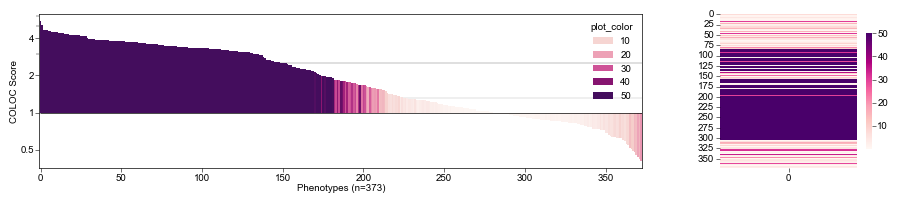

In [9]:
_, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(11, 2), gridspec_kw={'width_ratios':[7,2]})

df['plot_color'] = df.logq.apply(lambda z: min(z, 50))
sns.barplot(df.sort_values(by='Log2SizeOE', ascending=False), x='trait_pair', y='Log2SizeOE', hue='plot_color', 
            palette='RdPu', width=1, zorder=5, ax=ax1)
_ = ax1.set_xticks([])
ax1.hlines(y=[ np.log2(2.5),], xmin=-0.5, xmax=373, linestyle='-', color='black', alpha=0.6, 
           linewidth=0.3, zorder=0)
ax1.hlines(y=[ np.log2(1.3),], xmin=-0.5, xmax=373, linestyle='-', color='black', alpha=0.3, 
           linewidth=0.3, zorder=0)
ax1.hlines(y=0, xmin=-0.5, xmax=373.5, color='black', linewidth=0.5, zorder=6)
ax1.set_xlim(-0.75, 372.75)

ax1.set_yticks([-1, 0, 1, 2], labels=[0.5, 1, 2, 4])
_ = ax1.set_yticks(np.log2([3,5,6]), minor=True)
ax1.set_ylabel('COLOC Score')
ax1.set_xlabel(f'Phenotypes (n={len(df)})')
ax1.set_xticks([0, 50, 100, 150, 200, 250, 300, 350], labels = [0, 50, 100, 150, 200, 250, 300, 350])
sns.heatmap(df.plot_color.values.reshape(373, 1), cmap='RdPu', cbar_kws={'shrink':0.75})

In [10]:
print('Total sig coloc', len(df[(df.Log2SizeOE > 0) & (df.q < 0.05)]))
print('Total sig coloc %', f'{100*len(df[(df.Log2SizeOE > 0) & (df.q < 0.05)])/373:.1f}')

Total sig coloc 254
Total sig coloc % 68.1


In [11]:
print('Total strong', len(df[(df.Log2SizeOE > np.log2(2))& (df.q < 0.05)]))
print('Total strong %', 100*len(df[(df.Log2SizeOE > np.log2(2))& (df.q < 0.05)])/373)

Total strong 174
Total strong % 46.64879356568365


## Figure 2C - Categorical vs Continuous

In [12]:
info_df = pd.read_csv(os.path.join(datadir, 'outputs/STable1.tsv'), sep='\t', usecols=['Mapped EFO', 'Trait Type', 
                                                                              'Biological Domain', 'Mapped Trait']).drop_duplicates()
info_df.columns = ['TRAIT', 'EFO', 'trait_type', 'Domain']

In [13]:
type_df = df.merge(info_df.loc[:, ['EFO', 'trait_type', 'Domain']].drop_duplicates(), on='EFO', how='inner')

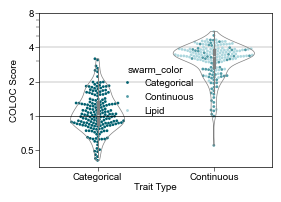

In [14]:
_ = plt.figure(figsize=(3,2))

type_df['swarm_color'] = type_df.apply(lambda x: 'Lipid' if x.Domain=='Lipid Measurement' else x.trait_type, axis=1)
sns.violinplot(type_df, x='trait_type', y='Log2SizeOE', cut=0, fill=0,color='grey', zorder=2, linewidth=0.5, width=0.7)
sns.swarmplot(type_df, x='trait_type', y='Log2SizeOE', hue='swarm_color', zorder=1, 
              palette=['#00606f', '#509aa5', '#ADD7DE'],  s=2)

ax1 = plt.gca()

ax1.hlines(y=[1, 2], xmin=-0.5, xmax=1.5, linestyle='-', color='grey', 
           linewidth=0.3, zorder=0)
ax1.hlines(y=0, xmin=-0.5, xmax=1.5, color='black', linewidth=0.5, zorder=6)
ax1.set_xlim(-0.5, 1.5)
ax1.set_ylim(-1.5, 3)
ax1.set_yticks([-1, 0, 1, 2, 3], labels=[0.5, 1, 2, 4, 8])
_ = ax1.set_yticks(np.log2([3,5,6, 7, 8]), minor=True)
ax1.set_xlabel('Trait Type')
_ = ax1.set_xticks([0,1], labels=['Categorical', 'Continuous'])
_ = ax1.set_ylabel('COLOC Score')
#plt.savefig(os.path.join(figdir, 'cat_vs_cont_stretch.svg'), bbox_inches='tight')

In [15]:
mannwhitneyu(type_df[type_df.trait_type=='Categorical'].Log2SizeOE.values,type_df[(type_df.trait_type=='Continuous')].Log2SizeOE.values )

MannwhitneyuResult(statistic=1173.0, pvalue=1.0565521566904869e-54)

In [16]:
print('Average COLOC, Lipid Measurement:', f'{np.mean([2*x for x in type_df[type_df.Domain=="Lipid Measurement"].Log2SizeOE.values]):.1f}')

Average COLOC, Lipid Measurement: 3.6


### Top Categorical traits

In [17]:
cat_df = type_df[type_df.trait_type=='Categorical'].sort_values('COLOC Score', ascending=False)

In [18]:
cat_df[(cat_df['COLOC Score']>1) & (cat_df['q'] < 0.05)].head(10)

,EFO,Trait,Common Study,Rare Study,Analysis Set,nCommon,nRare,nShared,pShared,Network,...,COLOC Score,COLOC p,COLOC -logp,trait_pair,q,logq,plot_color,trait_type,Domain,swarm_color
75,EFO_0004251,myeloproliferative disorder,GCST90000032,36138231,Initial,9,5,1,0.002366,PCNet2.0,...,3.170263,0.000000e+00,250.000000,36138231_EFO_0004251_GCST90000032_EFO_0004251,0.000000e+00,250.000000,50.000000,Categorical,Neoplasm,Categorical
11,EFO_0000384,Crohn's disease,GCST90446792,34375979,Initial,98,3,1,0.015395,PCNet2.0,...,3.094056,8.588000e-206,205.066108,34375979_EFO_0000384_GCST90446792_EFO_0000384,2.321249e-205,204.634278,50.000000,Categorical,Gastrointestinal,Categorical
136,EFO_0005854,allergic rhinitis,GCST009719,34375979,Initial,12,4,0,1.000000,PCNet2.0,...,2.740630,1.449000e-172,171.838932,34375979_EFO_0005854_GCST009719_EFO_0005854,3.753312e-172,171.425585,50.000000,Categorical,Immunological,Categorical
41,EFO_0002496,actinic keratosis,GCST90095184,34375979,Initial,8,3,1,0.001263,PCNet2.0,...,2.612515,6.959000e-140,139.157453,34375979_EFO_0002496_GCST90095184_EFO_0002496,1.730471e-139,138.761836,50.000000,Categorical,Dermatological,Categorical
45,EFO_0003756,autism spectrum disorder,GCST007556,35982160,Initial,20,119,0,1.000000,PCNet2.0,...,2.504445,1.263000e-192,191.898597,35982160_EFO_0003756_GCST007556_EFO_0003756,3.341128e-192,191.476107,50.000000,Categorical,Psychiatric,Categorical
119,EFO_0004799,cholelithiasis,GCST90018819,34375979,Initial,26,41,1,0.054653,PCNet2.0,...,2.434674,2.979000e-120,119.525929,34375979_EFO_0004799_GCST90018819_EFO_0004799,7.077497e-120,119.150120,50.000000,Categorical,Gastrointestinal,Categorical
14,EFO_0000407,dilated cardiomyopathy,GCST011210,34375979,Initial,5,18,1,0.004728,PCNet2.0,...,2.211523,5.676000e-102,101.245958,34375979_EFO_0000407_GCST011210_EFO_0000407,1.323217e-101,100.878369,50.000000,Categorical,Cardiovascular,Categorical
55,EFO_0003882,osteoporosis,GCST90018887,34375979,Initial,8,6,0,1.000000,PCNet2.0,...,1.980824,3.508000e-40,39.454940,34375979_EFO_0003882_GCST90018887_EFO_0003882,7.072886e-40,39.150403,39.150403,Categorical,Skeletal,Categorical
74,EFO_0004244,interstitial lung disease,GCST90018863,34375979,Initial,5,9,1,0.002366,PCNet2.0,...,1.978082,2.431000e-75,74.614215,34375979_EFO_0004244_GCST90018863_EFO_0004244,5.302708e-75,74.275502,50.000000,Categorical,Respiratory,Categorical
72,EFO_0004238,hearing loss,GCST90132906,34375979,Initial,32,22,0,1.000000,PCNet2.0,...,1.963389,2.875000e-48,47.541362,34375979_EFO_0004238_GCST90132906_EFO_0004238,5.924724e-48,47.227332,47.227332,Categorical,EarNoseThroat,Categorical


## Figure 2D - COLOC by domain

In [19]:
domain_map = {d:d for d in type_df.Domain.unique()}
domain_map['Pain'] = 'Other'
domain_map['Hepatic'] = 'Other'
type_df['Domain'] = type_df.Domain.map(domain_map)

In [20]:
domain_counts = pd.DataFrame({'total':type_df.groupby('Domain').EFO.count(), 
             'Colocalized': type_df[(type_df.q < 0.05) & (type_df.Log2SizeOE > 0)].groupby('Domain').EFO.count()}).fillna(0)
domain_counts['fraction'] = domain_counts.Colocalized / domain_counts.total

In [21]:
order = type_df.groupby('Domain').Log2SizeOE.median().sort_values().index[::-1]

In [22]:
percent_continuous = type_df.groupby('Domain').trait_type.value_counts().reset_index().pivot(index='Domain', columns='trait_type', values='count'
                                                                                            ).reset_index().fillna(0)
percent_continuous['frac'] = percent_continuous['Continuous']/(percent_continuous['Categorical']+percent_continuous['Continuous'])

Text(0, 0.5, '% Cont.')

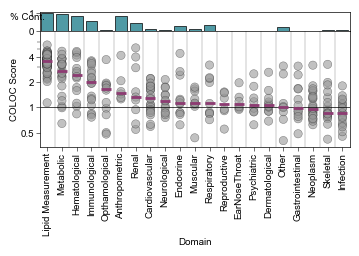

In [23]:
_, [ax2, ax1] = plt.subplots(nrows=2, ncols=1, figsize=(4, 1.75), gridspec_kw={'height_ratios':[0.5,3], 'hspace':0}, sharex=True)
sns.stripplot(type_df, x='Domain', y='Log2SizeOE', hue='Domain', jitter=0, s=6,ax=ax1,
               alpha=0.6, legend=False, palette=['#999999', '#999999']*10+['#999999'], order=order, hue_order=order,
             edgecolor='#333333', linewidth=0.35)
percent_contuinuous = type_df.groupby('Domain').trait_type.value_counts()
sns.barplot(percent_continuous, x='Domain', y='frac', ax=ax2, edgecolor='black', saturation=1, color='#509aa5')

# add a median bar for each value of x
sns.pointplot(type_df.groupby('Domain').Log2SizeOE.median().reset_index(), x='Domain', y='Log2SizeOE', color='#8d3b72', markers='_', dodge=True, order=order, zorder=200,
              linestyle='none', markersize=7, ax=ax1)#, hue='Domain', palette=['darkblue', 'royalblue']*10+['darkblue'], hue_order=order)
ax1.tick_params(axis='x', rotation=90)
ax1.hlines(y=0, xmin=-0.5, xmax=20.5, color='black',linewidth=0.5, linestyle='-', zorder=100)
ax1.vlines(x=[i+0.5 for i in range(20)], ymin=-1.55, ymax=3, linewidth=0.3, color='grey')
ax1.set_xlim(-0.5, 20.5)
ax1.set_ylim(-1.55, 3)
ax1.set_yticks([-1, 0, 1, 2], labels=[0.5, 1, 2, 4])
_ = ax1.set_yticks(np.log2([3,5,6]), minor=True)
plt.ylabel('COLOC Score')
ax2.set_ylabel('% Cont.', rotation=0)

## Supplemental Figure 1B - Domain COLOC vs Shared Genes

In [24]:
type_df['SizeOE'] = type_df.Log2SizeOE.apply(lambda x: 2**x)

In [25]:
def get_mean_and_sem_per_domain(initial_df, x_col, y_col):
    plt_df = initial_df.loc[:, ('Domain', x_col, y_col)].groupby('Domain').mean().reset_index()
    plt_sem = initial_df.loc[:, ('Domain', x_col, y_col)].groupby('Domain').sem().reset_index()
    plt_df = plt_df.merge(plt_sem, on='Domain', suffixes=('_mean', '_sem'))
    plt_df['x_high'] = plt_df.apply(lambda x: x[x_col + '_mean'] + x[x_col+'_sem'], axis=1)
    plt_df['x_low'] = plt_df.apply(lambda x: max(x[x_col + '_mean'] - x[x_col+'_sem'], 0), axis=1)
    plt_df['y_high'] = plt_df.apply(lambda x: x[y_col + '_mean'] + x[y_col+'_sem'], axis=1)
    plt_df['y_low'] = plt_df.apply(lambda x: max(x[y_col + '_mean'] - x[y_col+'_sem'], 0), axis=1)
    count_df = initial_df.Domain.value_counts().to_dict()
    plt_df['Count'] = plt_df.Domain.apply(lambda x: np.log10(count_df[x]))
    if y_col == 'SizeOE':
        plt_df['log2SizeOE'] = plt_df.SizeOE_mean.apply(lambda x: np.log2(x))
        plt_df['y_high'] = plt_df.y_high.apply(lambda x: np.log2(x))
        plt_df['y_low'] = plt_df.y_low.apply(lambda x: np.log2(x))
    r = plt_df.loc[:, (x_col+'_mean', y_col +'_mean')].corr(method='spearman').iloc[0,1]
    return plt_df, r

def plot_domain_scatter(plt_df, x_col, y_col, color, annotate=False,):
    _ = plt.figure(figsize=(2.5,2.5))
    ax = plt.gca()
    sns.scatterplot(plt_df, x=x_col, y=y_col, color=color, size='Count', zorder=3, edgecolor='black', linewidth=0.25)
    ax.hlines(y=plt_df[y_col], xmin=plt_df.x_low, xmax=plt_df.x_high, color=color, linewidth=0.3)
    ax.vlines(x=plt_df[x_col], ymin=plt_df.y_low, ymax=plt_df.y_high, color=color, linewidth=0.3)
    if annotate:
        for i in range(len(plt_df)):
            ax.text(x=plt_df[x_col][i], y=plt_df[y_col][i], s=plt_df.Domain[i])
    return ax

In [26]:
plt_df, r = get_mean_and_sem_per_domain(type_df, 'nShared', 'SizeOE')

Text(0.5, 0, '# Shared Genes')

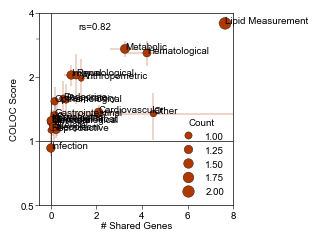

In [27]:
ax = plot_domain_scatter(plt_df, 'nShared_mean', 'log2SizeOE', color=shared, annotate=True)
ax.hlines(y=0, xmin=-0.5, xmax=8, color='black', linewidth=0.5, zorder=1)
ax.vlines(x=0, ymin=-1, ymax=2, color='black', linewidth=0.5, zorder=2)
ax.set_xlim(-0.5,8)
ax.text(x=1.2, y=1.75, s=f'rs={r:.2f}')    
ax.set_yticks([-1, 0, 1, 2], labels=[0.5, 1, 2, 4])
_ = ax.set_yticks(np.log2([3,5]), minor=True)
ax.set_ylim(-1.,2)
ax.set_ylabel('COLOC Score')
ax.set_xlabel('# Shared Genes')

## Synthetic Associations

### Identify traits for testing

In [28]:
st2 = pd.read_csv(os.path.join(cwd, '../outputs/STable2.tsv'), sep='\t')

In [29]:
st2 = st2[st2['Analysis Set']=='Initial'].sort_values(by='pShared', ascending=True)

### Randomly select 10 traits with > 1 shared input gene

In [30]:
len(st2[st2.nShared>2])

143

In [31]:
traits = st2[st2.nShared>2].iloc[[ 13,  20,  42,  54,  92,  98, 107, 120, 131, 142]]

Add Crohn's Disease (contains a known synthetic association)

In [32]:
traits = pd.concat([traits, st2[st2.EFO=='EFO_0000384']])

### Create new genesets, treating all shared genes as synthetic associations

All shared genes are assumed to be the result of causal rare variants and thus are removed from the CVG set

In [33]:
st1 = pd.read_csv(os.path.join(cwd, '../outputs/STable1.tsv'), sep='\t')
st1 = st1[st1.Set=='Initial']

In [34]:
for i in range(11):
    trait_info = traits.iloc[i]
    r_genes = load_full_gene_profile(os.path.join(datadir, 'outputs', f'{trait_info["Rare Study"]}_{trait_info["EFO"]}_RV.txt'), p_th=0.05, return_dict=False)
    c_genes = load_full_gene_profile(os.path.join(datadir, 'outputs',  f'{trait_info["Common Study"]}_{trait_info["EFO"]}_CV.txt'), p_th=0.05, return_dict=False)
    shared_genes = set(r_genes.Entrez).intersection(set(c_genes.Entrez))
    c_genes_drop = c_genes[~c_genes.Entrez.isin(shared_genes)]
    c_genes_drop.to_csv(os.path.join(datadir, 'outputs',  f'SYN_{trait_info["Common Study"]}_{trait_info["EFO"]}_CV.txt'), sep='\t', index=False)
    r_genes.to_csv(os.path.join(datadir, 'outputs', f'SYN_{trait_info["Rare Study"]}_{trait_info["EFO"]}_RV.txt'), sep='\t', index=False)                                              

### Load the NetColoc results for synthetic genesets

In [35]:
synthetic_results = pd.read_csv(os.path.join(datadir, 'outputs/STable6.tsv'), sep='\t')
synthetic_results = synthetic_results[synthetic_results.Test=='Synthetic']

In [36]:
diff_order = synthetic_results.pivot(columns='Test Annotation', index='EFO', values='Log2SizeOE')
diff_order['diff'] = diff_order['Synthetic'] / diff_order['Original']
diff_order = diff_order.sort_values(by='diff', ascending=False)

In [37]:
traits['perRare'] = traits.nShared / traits.nRare
traits['perCommon'] = traits.nShared / traits.nCommon
traits['logPshared'] = traits.pShared.apply(lambda x: -1 * np.log10(x + 1e-50))

In [38]:
efo_map = {'EFO_0004842': 'Eosinophil Count',
 'EFO_0022242': 'Cholesterol:Total lipids in S-VLDL %',
 'EFO_0004530': 'Triglyceride meas.',
 'EFO_0022248': 'Cholesteryl esters:total lipids in L-HDL %',
 'EFO_0004509': 'Hemoglobin meas.',
 'EFO_0009767': 'Glycine meas.',
 'EFO_0022275': 'Free cholesterol in XS-VLDL meas.',
 'EFO_0022238': 'Cholesterol:total lipids in M-LDL %',
 'EFO_0007985': 'Platelet crit',
 'EFO_0022293': 'Phospholipids in HDL meas.',
 'EFO_0000384': "Crohn's disease"}

### Supplemental Figure 1C - Synthetic Associations

Text(0, 0.5, 'COLOC Score')

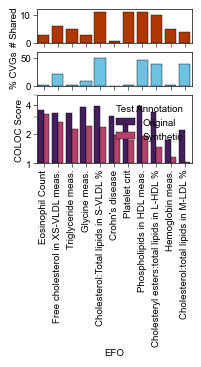

In [39]:
_, [ax2,ax1,ax] = plt.subplots(ncols=1, nrows=3, figsize=(2,2), height_ratios=[1,1,2], sharex=True)
ax = plt.gca()
sns.barplot(synthetic_results.reset_index(), y='Log2SizeOE', x='EFO', hue='Test Annotation', ax=ax, order=diff_order.index.values, 
           palette=[purple, raspberry], saturation=1, edgecolor='black', linewidth=0.3)
_ = ax.set_xticks([i for i in range(11)], [efo_map[x.get_text()] for x in ax.get_xticklabels()], rotation=90)
sns.barplot(traits, y='perCommon', x='EFO', ax=ax1, color=blue, saturation=1, edgecolor='black', linewidth=0.3)
sns.barplot(traits, y='nShared', x='EFO', ax=ax2, color=shared, linewidth=0.3, saturation=1, edgecolor='black')

ax.set_yticks([ 0, 1, 2], labels=[1, 2, 4])
_ = ax.set_yticks(np.log2([3,5]), minor=True)
ax2.set_ylim(0, 12)
ax1.set_ylim(0, 0.6)
ax1.set_yticks([0, 0.5], [0, 50])
ax2.set_ylabel('# Shared')
ax1.set_ylabel('% CVGs')
ax.set_ylabel('COLOC Score')